In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-movies-dataset


 # Load the Dataset

In [3]:
import os
import pandas as pd

In [4]:
movies = pd.read_csv(os.path.join(path, "movies_metadata.csv"))
print(movies.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

/tmp/ipython-input-1610430134.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv(os.path.join(path, "movies_metadata.csv"))


In [5]:
ratings = pd.read_csv(os.path.join(path, "ratings.csv"))
print(ratings.head())

   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556


In [6]:
print("Movies Shape:", movies.shape)
print("Ratings Shape;", ratings.shape)

Movies Shape: (45466, 24)
Ratings Shape; (26024289, 4)


# Data Cleaning

In [7]:
movies = movies[['id', 'title', 'genres']]
print(movies.head())


      id                        title  \
0    862                    Toy Story   
1   8844                      Jumanji   
2  15602             Grumpier Old Men   
3  31357            Waiting to Exhale   
4  11862  Father of the Bride Part II   

                                              genres  
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...  
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...  
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  
4                     [{'id': 35, 'name': 'Comedy'}]  


In [8]:
#Convert IDs to numeric
movies['id'] = pd.to_numeric(movies['id'], errors = 'coerce')
print(movies.head())

        id                        title  \
0    862.0                    Toy Story   
1   8844.0                      Jumanji   
2  15602.0             Grumpier Old Men   
3  31357.0            Waiting to Exhale   
4  11862.0  Father of the Bride Part II   

                                              genres  
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...  
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...  
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  
4                     [{'id': 35, 'name': 'Comedy'}]  


In [9]:
#Drop NA
movies = movies.dropna(subset=['id'])

print(movies.head())

        id                        title  \
0    862.0                    Toy Story   
1   8844.0                      Jumanji   
2  15602.0             Grumpier Old Men   
3  31357.0            Waiting to Exhale   
4  11862.0  Father of the Bride Part II   

                                              genres  
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...  
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...  
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  
4                     [{'id': 35, 'name': 'Comedy'}]  


In [10]:
print(movies.shape)

(45463, 3)


In [11]:
ratings = ratings[['userId', 'movieId', 'rating']]

ratings['movieId'] = pd.to_numeric(ratings['movieId'], errors='coerce')

ratings = ratings.dropna()

In [12]:
print(ratings.head())

   userId  movieId  rating
0       1      110     1.0
1       1      147     4.5
2       1      858     5.0
3       1     1221     5.0
4       1     1246     5.0


# Exploratory Data Analysis (EDA)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

1. Ratings Distribution

In [13]:
import matplotlib.pyplot as plt

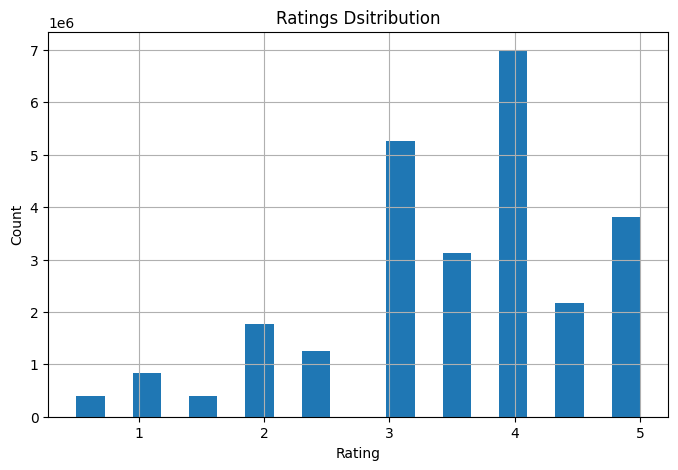

In [13]:
ratings['rating'].hist(bins=20, figsize=(8,5))
plt.title('Ratings Dsitribution')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

2. Most Rated Movies

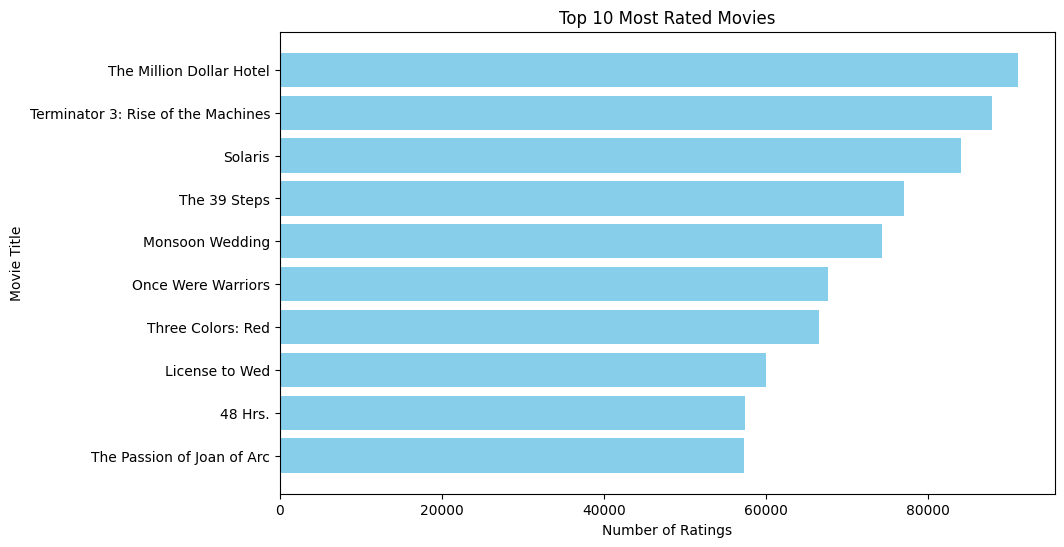

In [14]:
import matplotlib.pyplot as plt

# Count ratings per movie
rating_counts = ratings.groupby('movieId').size().reset_index(name='count')

# Merge with movies dataset to get titles
movie_counts = rating_counts.merge(movies, left_on='movieId', right_on='id')

# Sort and pick top 10
top10 = movie_counts.sort_values('count', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
plt.barh(top10['title'], top10['count'], color='skyblue')
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.title("Top 10 Most Rated Movies")
plt.gca().invert_yaxis()  # so the most rated appears at the top
plt.show()


3. Heatmap (User vs Movie Matrix)

In [22]:
import ast

# Convert JSON-like strings to Python objects
movies['genres'] = movies['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Extract just the "name" field
movies['genres'] = movies['genres'].apply(lambda x: [d['name'] for d in x])

# Explode into one row per genre
movies_expanded = movies.explode('genres')

# Merge ratings with clean genres
df = ratings.merge(movies_expanded, left_on='movieId', right_on='id')


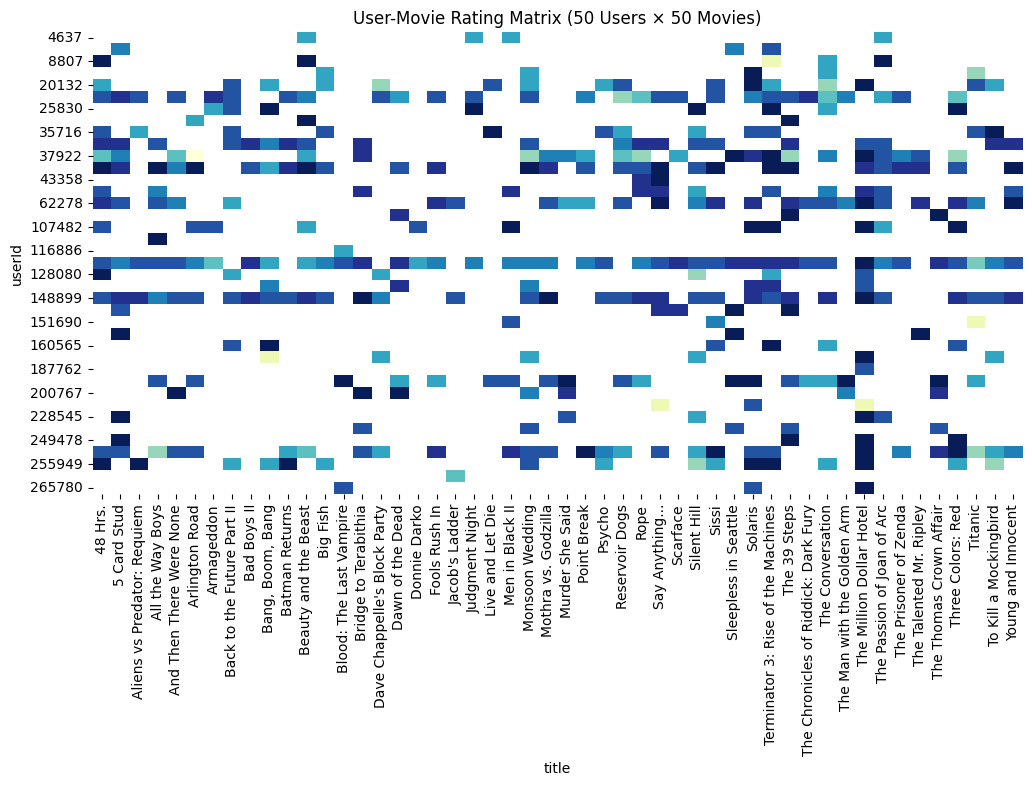

In [23]:
sample_users = df['userId'].drop_duplicates().sample(50, random_state=42)
sample_movies = df['title'].value_counts().head(50).index

subset = df[df['userId'].isin(sample_users) & df['title'].isin(sample_movies)]

user_movie_matrix = subset.pivot_table(index='userId', columns='title', values='rating')

plt.figure(figsize=(12,6))
sns.heatmap(user_movie_matrix, cmap="YlGnBu", cbar=False)
plt.title("User-Movie Rating Matrix (50 Users × 50 Movies)")
plt.show()


4. Boxplot per Genre

/tmp/ipython-input-835018797.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='genres', data=top30_genres.sort_values('avg_rating', ascending=False), palette="viridis")


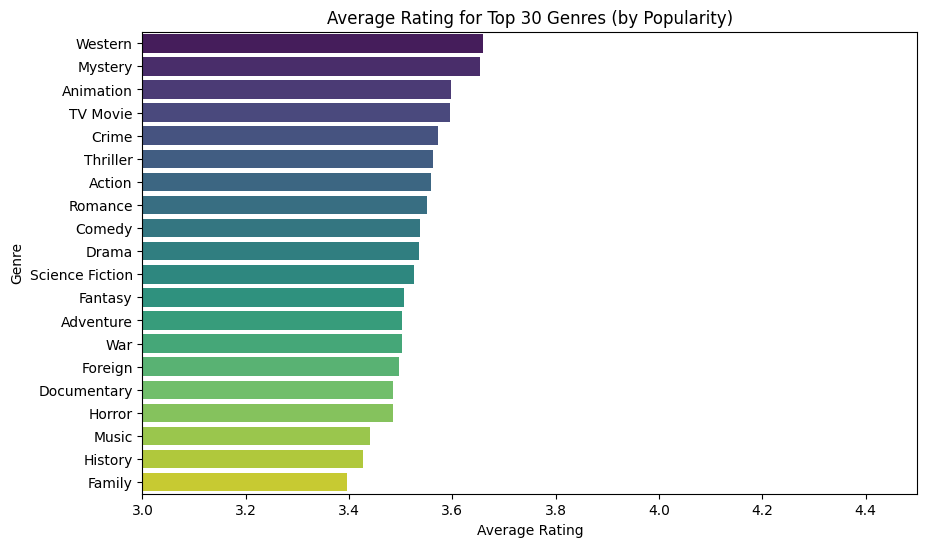

In [24]:
# Compute avg rating + count per genre
genre_stats = df.groupby('genres').agg(
    avg_rating=('rating','mean'),
    rating_count=('rating','count')
).reset_index()

# Pick top 10 genres by rating_count (most popular ones)
top30_genres = genre_stats.sort_values('rating_count', ascending=False).head(30)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='avg_rating', y='genres', data=top30_genres.sort_values('avg_rating', ascending=False), palette="viridis")
plt.title("Average Rating for Top 30 Genres (by Popularity)")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.xlim(3.0, 4.5)   # zoom into rating range
plt.show()


5. Popularity vs Rating (Scatterplot)

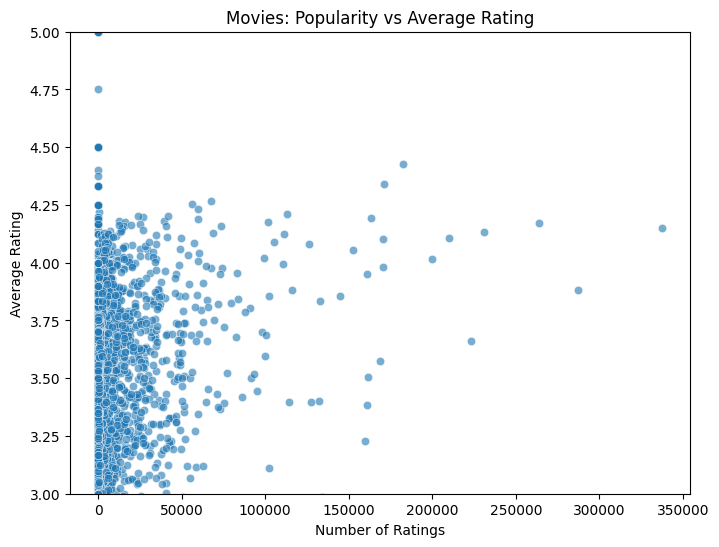

In [25]:
movie_stats = df.groupby('title').agg(
    avg_rating=('rating','mean'),
    rating_count=('rating','count')
)
plt.figure(figsize=(8,6))
sns.scatterplot(x='rating_count', y='avg_rating', data=movie_stats, alpha=0.6)
plt.title("Movies: Popularity vs Average Rating")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.ylim(3.0, 5.0)
plt.show()
